# Bushcraft vs Witchcraft
## Modeling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV,StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data/df_processed.csv')

## Count Vectorizer & Multinomial Naive Bayes

#### Model Prep

In [3]:
X = df['cleaned_title_body_str'] 
y = df['num_subreddit']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline accuracy

In [5]:
#good even split
y_test.value_counts(normalize = True)

0    0.503089
1    0.496911
Name: num_subreddit, dtype: float64

#### Transform X

In [6]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

#### Cvec top occuring words

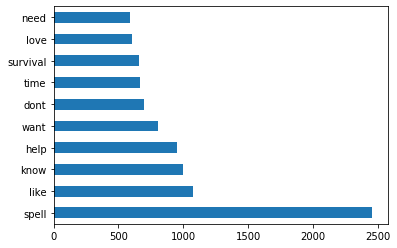

In [7]:
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

X_train_df.sum().sort_values(ascending=False).head(10).plot(kind= 'barh');

#### Creating pipeline

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [9]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [10]:
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

#### Gridsearch

In [11]:
gs_cv = GridSearchCV(pipe, 
                  pipe_params, 
                  cv = 5)

In [12]:
gs_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [13]:
gs_cv.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

#### Evaluating Model

In [14]:
gs_cv.best_score_

0.9780102437462844

In [15]:
gs_cv.score(X_test, y_test)

0.9787234042553191

In [16]:
gs_cv.score(X_train, y_train)

0.986468200270636

In [17]:
preds_cv = gs_cv.predict(X_test)

In [18]:
accuracy_score(y_test, preds_cv)

0.9787234042553191

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_cv).ravel()

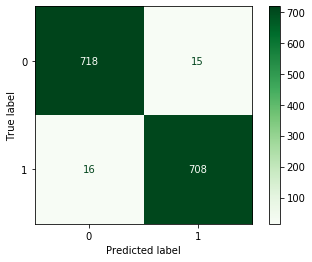

In [96]:
plot_confusion_matrix(gs_cv, X_test, y_test, cmap='Greens', values_format='d');

In [21]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn)/ (tp + fp + tn + fn)
misclassification = (fp + fn) / (tp + fp + tn + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
print('accuracy: ', accuracy)
print('misclassification: ', misclassification)

specificity:  0.9795361527967258
sensitivity:  0.9779005524861878
accuracy:  0.9787234042553191
misclassification:  0.02127659574468085


With this model I was able to classify the test set at 97.8% accuracy with 97.7% and 97.8% on Sensitivity and Specificity respectively. Although these are good scores, due to the nature of the subreddit posts being more contextual, I think I can make a better model by using TF-IDF to vectorize my text.

## Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer & Multinomial Naive Bayes

#### Transform X

In [22]:
tvec = TfidfVectorizer()

#### Tvec top occuring words

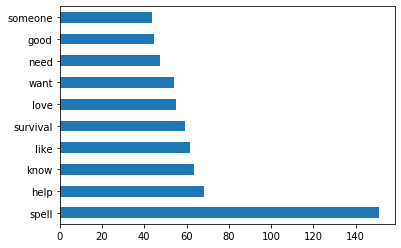

In [23]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

#### Creating pipeline

In [24]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [25]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

#### Gridsearch

In [26]:
gs_tvec = GridSearchCV(pipe_tvec, pipe_tvec_params,
                      cv = 5,
                      verbose = 1)

In [27]:
gs_tvec.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   21.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [28]:
gs_tvec.best_params_

{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

#### Evaluating Model

In [29]:
gs_tvec.best_score_

0.977670690995564

In [30]:
gs_tvec.score(X_test, y_test)

0.9835277968428278

In [31]:
gs_tvec.score(X_train, y_train)

0.9918809201623816

In [32]:
preds_tvec = gs_tvec.predict(X_test)

In [33]:
accuracy_score(y_test, preds_tvec)

0.9835277968428278

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

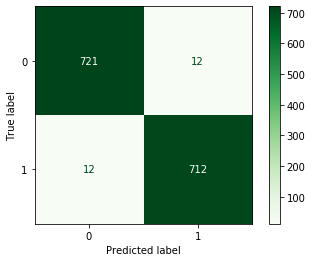

In [98]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Greens', values_format='d');

In [37]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn)/ (tp + fp + tn + fn)
misclassification = (fp + fn) / (tp + fp + tn + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
print('accuracy: ', accuracy)
print('misclassification: ', misclassification)

specificity:  0.9836289222373806
sensitivity:  0.9834254143646409
accuracy:  0.9835277968428278
misclassification:  0.016472203157172273


With this model I was able to classify the test set at 98.3% accuracy with 98.3% and 98.3% on Sensitivity and Specificity respectively. Not surprisingly, these are better scores than my first model using Count Vec for my text.

# Random Forest & Extra Trees

#### Model prep

In [38]:
X = df['cleaned_title_body_str']
y = df['num_subreddit']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline accuracy

In [40]:
y_test.value_counts(normalize = True)

0    0.503089
1    0.496911
Name: num_subreddit, dtype: float64

#### Transform X

In [41]:
cvec = CountVectorizer()
X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)

#### Model instantiation

In [49]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier(n_estimators=100)

#### RF vs ET Model Evaluation

In [50]:
cross_val_score(rf, X_train_vec, y_train, cv=5).mean()

0.9685387798966479

In [51]:
cross_val_score(et, X_train_vec, y_train, cv=5).mean()

0.966509466319111

#### GridSearch

In [52]:
rf_params = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [None, 1, 2, 3, 4, 5],  
    'min_samples_leaf' : [1, 2, 3],
}                                       

In [53]:
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [54]:
gs_rf.fit(X_train_vec, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [55]:
gs_rf.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}

#### Tuning & model evaluation

In [56]:
gs_rf.best_score_

0.9719223030136735

In [57]:
gs_rf.score(X_train_vec, y_train)

1.0

In [58]:
gs_rf.score(X_test_vec, y_test)

0.9725463280713795

In [59]:
rf = RandomForestClassifier(n_estimators = 150,max_depth=None, min_samples_leaf = 1)
rf.fit(X_train_vec,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [60]:
cross_val_score(rf, X_train_vec, y_train, cv=5).mean()

0.9702308272739744

In [61]:
rf.score(X_train_vec,y_train)

1.0

In [62]:
rf.score(X_test_vec,y_test)

0.9773507206588882

In [63]:
preds_rf = rf.predict(X_test_vec)

In [64]:
accuracy_score(y_test, preds_rf)

0.9773507206588882

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

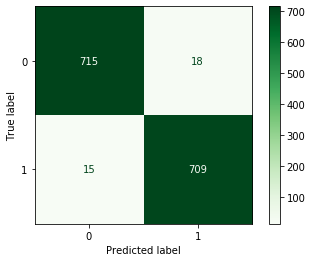

In [66]:
plot_confusion_matrix(rf, X_test_vec, y_test, cmap='Greens', values_format='d');

In [67]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn)/ (tp + fp + tn + fn)
misclassification = (fp + fn) / (tp + fp + tn + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
print('accuracy: ', accuracy)
print('misclassification: ', misclassification)

specificity:  0.975443383356071
sensitivity:  0.9792817679558011
accuracy:  0.9773507206588882
misclassification:  0.022649279341111873


With this model I was able to classify the test set at 97.7% accuracy with 97.9% and 97.5% on Sensitivity and Specificity respectively. However the train set was scored at 1.0 so this model is overfit. 

# Support Vector Machine

#### Model Prep

In [68]:
X = df['cleaned_title_body_str']
y = df['num_subreddit']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

#### Transform X

In [70]:
cvec = CountVectorizer()

In [71]:
X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)

#### Model instantiation

In [73]:
svc = SVC()

In [74]:
svc.fit(X_train_vec, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Model evaluation 

In [75]:
cross_val_score(svc, X_train_vec, y_train, cv=5).mean()

0.9448546897150958

In [76]:
preds_svc = svc.predict(X_test_vec)

In [78]:
svc.score(X_test_vec, y_test)

0.9478380233356212

In [79]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()

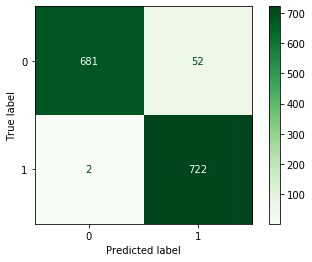

In [97]:
plot_confusion_matrix(svc, X_test_vec, y_test, cmap='Greens', values_format='d');

In [81]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn)/ (tp + fp + tn + fn)
misclassification = (fp + fn) / (tp + fp + tn + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
print('accuracy: ', accuracy)
print('misclassification: ', misclassification)

specificity:  0.8990450204638472
sensitivity:  0.9972375690607734
accuracy:  0.9478380233356212
misclassification:  0.05216197666437886


#### Grid search

In [82]:
svm_params = {
    'C': [1, 3],  
    'kernel': ['rbf', 'poly','sigmoid'], 
    'gamma' : ['scale', 'auto'],
}                                       

In [83]:
gs_svc = GridSearchCV(svc, param_grid=svm_params, cv=5)

In [84]:
gs_svc.fit(X_train_vec, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [85]:
gs_svc.best_params_

{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}

#### Tuning & model evaluation

In [86]:
gs_svc.best_score_

0.9607576485114556

In [87]:
gs_svc.score(X_train_vec, y_train)

0.9895128552097429

In [88]:
svc = SVC(C = 3,
         kernel = 'rbf',
         gamma = 'scale')

svc.fit(X_train_vec, y_train)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [89]:
svc.score(X_train_vec,y_train)

0.9895128552097429

In [90]:
svc.score(X_test_vec,y_test)

0.9629375428963624

In [91]:
preds_svc = svc.predict(X_test_vec)

In [92]:
accuracy_score(y_test, preds_svc)

0.9629375428963624

In [93]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()

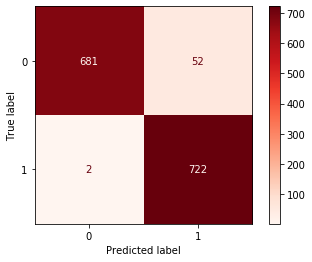

In [94]:
plot_confusion_matrix(svc, X_test_vec, y_test, cmap='Reds', values_format='d');

In [95]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = (tp + tn)/ (tp + fp + tn + fn)
misclassification = (fp + fn) / (tp + fp + tn + fn)
print('specificity: ', specificity)
print('sensitivity: ', sensitivity)
print('accuracy: ', accuracy)
print('misclassification: ', misclassification)

specificity:  0.9290586630286494
sensitivity:  0.9972375690607734
accuracy:  0.9629375428963624
misclassification:  0.03706245710363761


With this model I was able to classify the test set at 96.2% accuracy with 99% and 92.9% on Sensitivity and Specificity respectively. The training score is 98% which has the largest gap from the testing data in all of my models. Therefore this model has the highest bias from all of the models I have created.

# Reccomendations

|Test          |   SVC	|   RF	|  TF/MNB 	|   CVMNB	|  
|:-:           |:-:	    |:-:	|:-:	    |:-:	    |
|Test Accuracy |  .947  |  .979	|  .983	    |  .978	    | 
|Train Accuracy|    	|  1.	|  .99	    |  .986	    |
|Specificity   |  .899 	|  .979 |    .983   |  .979     |
|Sensitivity   |  .947 	|  .970 |   .983    |  .970     |
|Misclassification|  .52|  .024	|   .016    |  .024     |

Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer & Multinomial Naive Bayes is the most accurate model to differentiate Survival Subreddit from Spell Subreddit posts.

### Next Steps

To further investigat this data I would like to discover and explore the words that the TF/MND model missed. I would also like to analyse more witchy subreddits to make sure that my analysis can be generalized towards targeting witches in different groups.